# Wasserstein GAN (WGAN)

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import time
import glob
import imageio
from IPython import display
import cv2
import pathlib
import zipfile
import torch
import sys
import pandas as pd 

import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import MNIST

from skimage import io, transform

from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

# Device Mode

In [2]:
# Decide which device we want to run on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Generator

In [3]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_chan=1, hidden_dim=16):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            
            self.get_generator_block(z_dim, hidden_dim * 32, kernel_size=4, stride=1, padding=0),
            self.get_generator_block(hidden_dim * 32, hidden_dim * 16, kernel_size=4, stride = 2, padding=1),
            self.get_generator_block(hidden_dim * 16, hidden_dim * 8, kernel_size=4, stride = 2, padding=1),
            self.get_generator_block(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride = 2, padding=1),
            self.get_generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride = 2, padding=1),
            self.get_generator_final_block(hidden_dim * 2,im_chan,kernel_size=4,stride=2,padding=1)           

        )
        
        
    def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.ReLU(inplace=True),
        )
    
    
    def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
                nn.Tanh()
            )
    
    
    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)
    
    
    
summary(Generator(100).to(device), (100,))
print(Generator(100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,712
              ReLU-2            [-1, 512, 4, 4]               0
   ConvTranspose2d-3            [-1, 256, 8, 8]       2,097,408
              ReLU-4            [-1, 256, 8, 8]               0
   ConvTranspose2d-5          [-1, 128, 16, 16]         524,416
              ReLU-6          [-1, 128, 16, 16]               0
   ConvTranspose2d-7           [-1, 64, 32, 32]         131,136
              ReLU-8           [-1, 64, 32, 32]               0
   ConvTranspose2d-9           [-1, 32, 64, 64]          32,800
             ReLU-10           [-1, 32, 64, 64]               0
  ConvTranspose2d-11          [-1, 1, 128, 128]             513
             Tanh-12          [-1, 1, 128, 128]               0
Total params: 3,605,985
Trainable params: 3,605,985
Non-trainable params: 0
---------------------------

/home/paddy/miniconda3/envs/ml/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv_transpose2d(


# Critic / Discriminator

In [4]:
class Critic(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            self.get_critic_block(im_chan, hidden_dim * 2 , kernel_size=4, stride=2, padding=1),
            self.get_critic_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            self.get_critic_block(hidden_dim * 4, hidden_dim * 8, kernel_size=4, stride=2, padding=1),
            self.get_critic_block(hidden_dim * 8, hidden_dim * 16, kernel_size=4, stride=2, padding=1),
            self.get_critic_block(hidden_dim * 16, hidden_dim * 32, kernel_size=4, stride=2, padding=1),

            self.get_critic_final_block(hidden_dim * 32, 1, kernel_size=4, stride=2,padding=0),

        )

        
    def get_critic_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                #nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
        )
    
    
    def get_critic_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return  nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
            )
    
    def forward(self, image):
        return self.disc(image)
    
summary(Critic().to(device) , (1,128,128))
print(Critic())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             544
         LeakyReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          32,832
         LeakyReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         131,200
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,544
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
        LeakyReLU-10            [-1, 512, 4, 4]               0
           Conv2d-11              [-1, 1, 1, 1]           8,193
Total params: 2,794,977
Trainable params: 2,794,977
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forw

# Noise Creator Function

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

# MNIST Dataset Load

In [6]:
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import io
import os 
from pathlib import Path

z_dim = 100
img_size = 128
batch_size = 32

fixed_noise = get_noise(batch_size, z_dim, device=device)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

cdir = os.getcwd() 
path = os.path.dirname(cdir) + "/ed_rasters"
print(path)
image_paths = glob(path + '/*.png')

print(image_paths)

os.makedirs(Path(os.path.dirname(cdir),"checkpoints"),  exist_ok=True)

checkpoints = os.path.dirname(cdir) + "/checkpoints"

class ImageDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    

    def __getitem__(self, index):
        image_path = self.paths[index]
        image = io.imread(image_path)
        
        if self.transform:
            image_tensor = self.transform(image)
            
        return image_tensor

dataset = ImageDataset(image_paths, train_transform)
    
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)

/home/paddy/git/ed_rasters
['/home/paddy/git/ed_rasters/3305.png', '/home/paddy/git/ed_rasters/3374.png', '/home/paddy/git/ed_rasters/2924.png', '/home/paddy/git/ed_rasters/357.png', '/home/paddy/git/ed_rasters/111.png', '/home/paddy/git/ed_rasters/1948.png', '/home/paddy/git/ed_rasters/2673.png', '/home/paddy/git/ed_rasters/2086.png', '/home/paddy/git/ed_rasters/1582.png', '/home/paddy/git/ed_rasters/247.png', '/home/paddy/git/ed_rasters/705.png', '/home/paddy/git/ed_rasters/606.png', '/home/paddy/git/ed_rasters/1594.png', '/home/paddy/git/ed_rasters/2680.png', '/home/paddy/git/ed_rasters/1033.png', '/home/paddy/git/ed_rasters/125.png', '/home/paddy/git/ed_rasters/555.png', '/home/paddy/git/ed_rasters/1719.png', '/home/paddy/git/ed_rasters/2228.png', '/home/paddy/git/ed_rasters/706.png', '/home/paddy/git/ed_rasters/1825.png', '/home/paddy/git/ed_rasters/2697.png', '/home/paddy/git/ed_rasters/1299.png', '/home/paddy/git/ed_rasters/2156.png', '/home/paddy/git/ed_rasters/2065.png', '/hom

# Optimizer

In [7]:
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

        
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

crit  = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)        

# Gradient Penalty

In [8]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)
    
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

# Loss

In [9]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    return gen_loss

In [10]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

# Model Training Process

In [11]:
def get_gradient(crit, real, fake, epsilon):

    mixed_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_images)
    
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
        
    )[0]
    return gradient

In [12]:
def show_tensor_images(image_tensor, num_images=1, size=(1, 128, 128), show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    #if show_fig:
    #   #str(Path(os.path.dirname(cdir),f"country_rasters/{i}.png"))
    #   print(type(image_unflat.numpy()))
    #   print(image_unflat.numpy().shape)
    #   print(image_unflat)
    #   cv2.imwrite(str(Path(os.path.dirname(cdir),'image_at_epoch_{:04d}.png'.format(epoch))), image_unflat.numpy()*255)#cv2.flip(image_unflat.numpy()*255, 0))        
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 0/25 Total Steps:108	Total_Time : 19.714852	Loss_C : -65.750808	Loss_G : 712.420532	Loss_C_Mean : -91.203148	Loss_G_Mean : 908.694713	


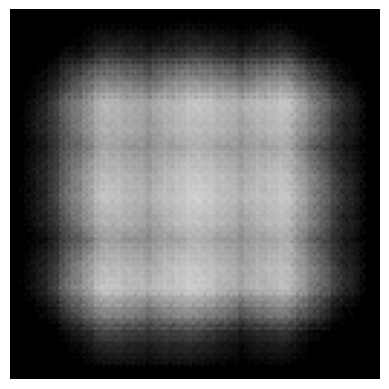

saving models: generator
Epoch: 1/25 Steps:108/108	Epoch_Run_Time: 19.845552	Loss_C : -44.344987	Loss_G : 241.095917	
Epoch: 1/25 Total Steps:216	Total_Time : 39.642930	Loss_C : -44.344987	Loss_G : 241.095917	Loss_C_Mean : -39.575217	Loss_G_Mean : 231.606501	
saving models: generator
Epoch: 2/25 Steps:108/108	Epoch_Run_Time: 20.184704	Loss_C : -17.301741	Loss_G : 145.068924	
Epoch: 2/25 Total Steps:324	Total_Time : 59.871873	Loss_C : -17.301741	Loss_G : 145.068924	Loss_C_Mean : -27.422788	Loss_G_Mean : 183.160425	
saving models: generator
Epoch: 3/25 Steps:108/108	Epoch_Run_Time: 20.117816	Loss_C : -13.970572	Loss_G : 113.603889	
Epoch: 3/25 Total Steps:432	Total_Time : 80.028450	Loss_C : -13.970572	Loss_G : 113.603889	Loss_C_Mean : -15.199063	Loss_G_Mean : 135.465539	
saving models: generator
Epoch: 4/25 Steps:108/108	Epoch_Run_Time: 20.103492	Loss_C : -11.324697	Loss_G : 108.785355	
Epoch: 4/25 Total Steps:540	Total_Time : 100.176521	Loss_C : -11.324697	Loss_G : 108.785355	Loss_C_Mea

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 5/25 Total Steps:648	Total_Time : 120.052532	Loss_C : -16.237228	Loss_G : 59.198128	Loss_C_Mean : -15.468325	Loss_G_Mean : 69.394834	


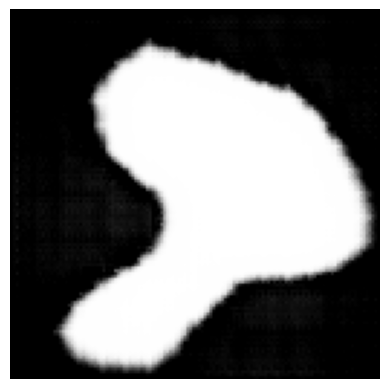

saving models: generator
Epoch: 6/25 Steps:108/108	Epoch_Run_Time: 20.238060	Loss_C : -17.434641	Loss_G : 13.959428	
Epoch: 6/25 Total Steps:756	Total_Time : 140.382668	Loss_C : -17.434641	Loss_G : 13.959428	Loss_C_Mean : -17.399204	Loss_G_Mean : 43.793183	
saving models: generator
Epoch: 7/25 Steps:108/108	Epoch_Run_Time: 20.198804	Loss_C : -18.669140	Loss_G : 7.233485		
Epoch: 7/25 Total Steps:864	Total_Time : 160.625507	Loss_C : -18.669140	Loss_G : 7.233485	Loss_C_Mean : -17.409549	Loss_G_Mean : 28.924379	
saving models: generator
Epoch: 8/25 Steps:108/108	Epoch_Run_Time: 20.179230	Loss_C : -16.144926	Loss_G : 3.528933			
Epoch: 8/25 Total Steps:972	Total_Time : 180.851734	Loss_C : -16.144926	Loss_G : 3.528933	Loss_C_Mean : -17.707491	Loss_G_Mean : 14.436582	
saving models: generator
Epoch: 9/25 Steps:108/108	Epoch_Run_Time: 20.213602	Loss_C : -17.063631	Loss_G : 5.824203	5	
Epoch: 9/25 Total Steps:1080	Total_Time : 201.107630	Loss_C : -17.063631	Loss_G : 5.824203	Loss_C_Mean : -17.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 10/25 Total Steps:1188	Total_Time : 220.938245	Loss_C : -15.047679	Loss_G : -15.074568	Loss_C_Mean : -18.136203	Loss_G_Mean : -18.750829	


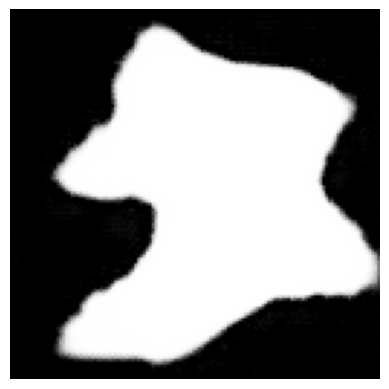

saving models: generator
Epoch: 11/25 Steps:108/108	Epoch_Run_Time: 19.979617	Loss_C : -15.920712	Loss_G : -44.914452	
Epoch: 11/25 Total Steps:1296	Total_Time : 241.003288	Loss_C : -15.920712	Loss_G : -44.914452	Loss_C_Mean : -17.867047	Loss_G_Mean : -21.305428	
saving models: generator
Epoch: 12/25 Steps:108/108	Epoch_Run_Time: 20.293731	Loss_C : -21.192930	Loss_G : 2.891382	2	
Epoch: 12/25 Total Steps:1404	Total_Time : 261.339228	Loss_C : -21.192930	Loss_G : 2.891382	Loss_C_Mean : -17.699619	Loss_G_Mean : -20.768112	
saving models: generator
Epoch: 13/25 Steps:108/108	Epoch_Run_Time: 20.247886	Loss_C : -18.479708	Loss_G : -26.832098	
Epoch: 13/25 Total Steps:1512	Total_Time : 281.631327	Loss_C : -18.479708	Loss_G : -26.832098	Loss_C_Mean : -17.388920	Loss_G_Mean : -13.180089	
saving models: generator
Epoch: 14/25 Steps:108/108	Epoch_Run_Time: 20.264455	Loss_C : -14.781255	Loss_G : -15.814175	
Epoch: 14/25 Total Steps:1620	Total_Time : 301.946111	Loss_C : -14.781255	Loss_G : -15.8141

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 15/25 Total Steps:1728	Total_Time : 321.771512	Loss_C : -17.262225	Loss_G : -29.688047	Loss_C_Mean : -17.408213	Loss_G_Mean : -13.087010	


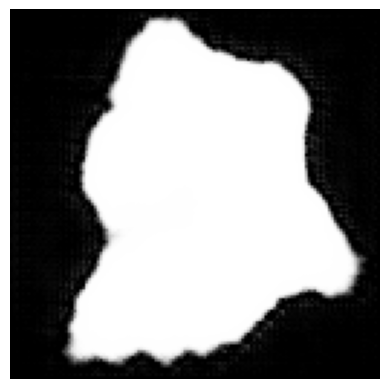

saving models: generator
Epoch: 16/25 Steps:108/108	Epoch_Run_Time: 19.683402	Loss_C : -17.914429	Loss_G : -0.626572		
Epoch: 16/25 Total Steps:1836	Total_Time : 341.541493	Loss_C : -17.914429	Loss_G : -0.626572	Loss_C_Mean : -17.407980	Loss_G_Mean : -10.547325	
saving models: generator
Epoch: 17/25 Steps:108/108	Epoch_Run_Time: 20.003242	Loss_C : -19.119160	Loss_G : 20.320446		
Epoch: 17/25 Total Steps:1944	Total_Time : 361.586937	Loss_C : -19.119160	Loss_G : 20.320446	Loss_C_Mean : -17.131826	Loss_G_Mean : -4.695102	
saving models: generator
Epoch: 18/25 Steps:108/108	Epoch_Run_Time: 19.991453	Loss_C : -13.673491	Loss_G : 7.214150			
Epoch: 18/25 Total Steps:2052	Total_Time : 381.617017	Loss_C : -13.673491	Loss_G : 7.214150	Loss_C_Mean : -16.837053	Loss_G_Mean : -6.903226	
saving models: generator
Epoch: 19/25 Steps:108/108	Epoch_Run_Time: 19.320938	Loss_C : -14.785009	Loss_G : -8.265906		
Epoch: 19/25 Total Steps:2160	Total_Time : 400.977235	Loss_C : -14.785009	Loss_G : -8.265906	Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch: 20/25 Total Steps:2268	Total_Time : 420.817424	Loss_C : -17.912310	Loss_G : 3.602458	Loss_C_Mean : -16.298124	Loss_G_Mean : -5.534985	


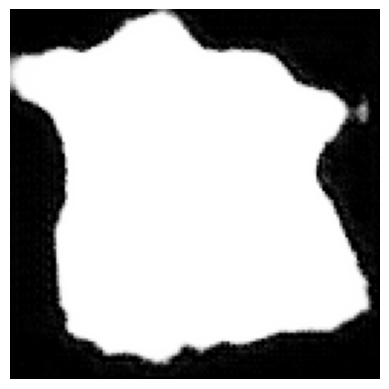

saving models: generator
Epoch: 21/25 Steps:108/108	Epoch_Run_Time: 19.800277	Loss_C : -18.087228	Loss_G : -28.851921	
Epoch: 21/25 Total Steps:2376	Total_Time : 440.711580	Loss_C : -18.087228	Loss_G : -28.851921	Loss_C_Mean : -16.135792	Loss_G_Mean : -7.634634	
saving models: generator
Epoch: 22/25 Steps:108/108	Epoch_Run_Time: 20.125115	Loss_C : -12.938693	Loss_G : -0.252696		
Epoch: 22/25 Total Steps:2484	Total_Time : 460.878992	Loss_C : -12.938693	Loss_G : -0.252696	Loss_C_Mean : -15.722480	Loss_G_Mean : -4.835364	
saving models: generator
Epoch: 23/25 Steps:108/108	Epoch_Run_Time: 20.138657	Loss_C : -15.197009	Loss_G : -10.075225	
Epoch: 23/25 Total Steps:2592	Total_Time : 481.060964	Loss_C : -15.197009	Loss_G : -10.075225	Loss_C_Mean : -15.552188	Loss_G_Mean : -3.809079	
saving models: generator
Epoch: 24/25 Steps:108/108	Epoch_Run_Time: 20.150495	Loss_C : -15.028985	Loss_G : -6.317577	
Epoch: 24/25 Total Steps:2700	Total_Time : 501.254591	Loss_C : -15.028985	Loss_G : -6.317577	L

In [13]:
n_epochs = 25
cur_step = 0
total_steps = 0
start_time = time.time()
cur_step = 0

generator_losses = []
critic_losses = []

C_mean_losses = []
G_mean_losses = []

c_lambda = 10
crit_repeats = 5
display_step = 50

for epoch in range(n_epochs):
    cur_step = 0
    start = time.time()
    for real in train_loader:
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]
        
        cur_step += 1
        total_steps += 1
        
        print_val = f"Epoch: {epoch}/{n_epochs} Steps:{cur_step}/{len(train_loader)}\t"
        print_val += f"Epoch_Run_Time: {(time.time()-start):.6f}\t"
        print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
        print_val += f"Loss_G : {gen_loss:.6f}\t"  
        print(print_val, end='\r',flush = True)

    print()
    gen_mean = sum(generator_losses[-cur_step:]) / cur_step
    crit_mean = sum(critic_losses[-cur_step:]) / cur_step
    
    C_mean_losses.append(crit_mean)
    G_mean_losses.append(gen_mean)
    
    print_val = f"Epoch: {epoch}/{n_epochs} Total Steps:{total_steps}\t"
    print_val += f"Total_Time : {(time.time() - start_time):.6f}\t"
    print_val += f"Loss_C : {mean_iteration_critic_loss:.6f}\t"
    print_val += f"Loss_G : {gen_loss:.6f}\t"
    print_val += f"Loss_C_Mean : {crit_mean:.6f}\t"
    print_val += f"Loss_G_Mean : {gen_mean:.6f}\t"
    print(print_val)
    
    fake_noise = fixed_noise
    fake = gen(fake_noise)
    
    if epoch % 5 == 0:
        show_tensor_images(fake, show_fig=True,epoch=epoch)
    
    cur_step = 0
    print("saving models: generator")
    torch.save(gen.state_dict(), checkpoints + "gen_checkpoint_ED.pth")
    torch.save(crit.state_dict(), checkpoints + "crit_checkpoint_ED.pth")

    

# After Tranning Loss Visualization

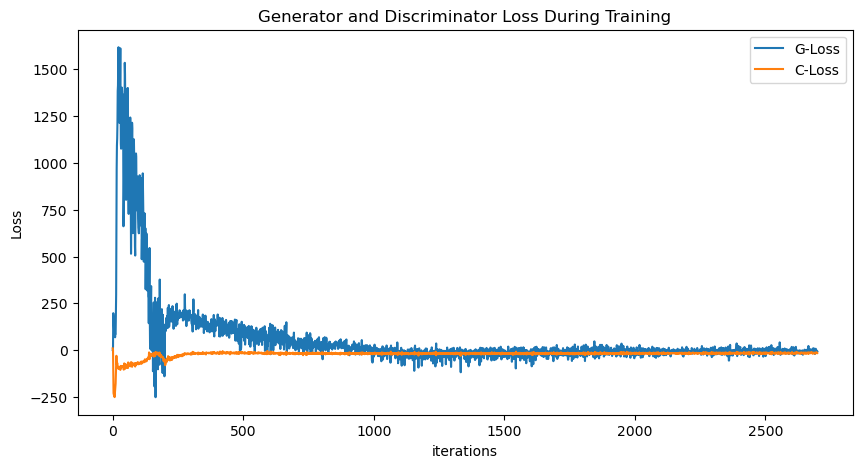

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="G-Loss")
plt.plot(critic_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

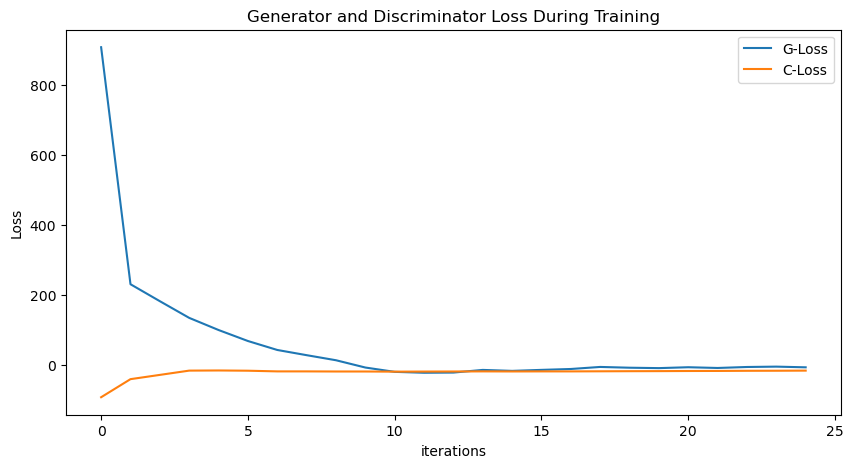

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_mean_losses,label="G-Loss")
plt.plot(C_mean_losses,label="C-Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Animated GIF Create & Show

In [16]:
from glob import glob
anim_file = 'WGAN-GAN.gif'

#with imageio.get_writer(anim_file, mode='I') as writer:
  #filenames = glob.glob('image*.png')
#  filenames = glob('image*.png')
#  filenames = sorted(filenames)
#  for filename in filenames:
#    image = imageio.imread(filename)
#    writer.append_data(image)
#  image = imageio.imread(filename)
#  writer.append_data(image)


#!pip install -q git+https://github.com/tensorflow/docs
#import tensorflow_docs.vis.embed as embed
#embed.embed_file(anim_file)

# Testing WGAN

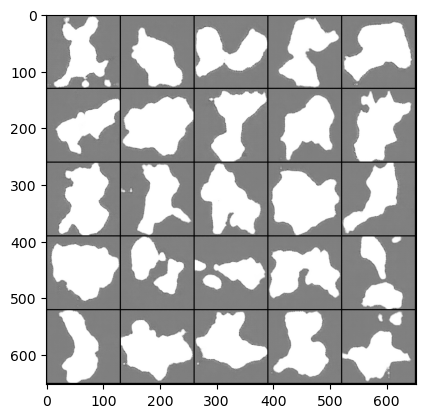

In [17]:
def show_new_gen_images(tensor_img, num_img=25):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze(),cmap='gray')
    plt.show()

num_image = 25
noise = get_noise(num_image, z_dim, device=device)
with torch.no_grad():
    fake_img = gen(noise)

show_new_gen_images(fake_img.reshape(num_image,1,128,128))

In [18]:
print(fake_img)

tensor([[[[-0.0403, -0.0182, -0.0066,  ..., -0.0339, -0.0151, -0.0513],
          [-0.0242,  0.0127,  0.0086,  ..., -0.0051, -0.0095, -0.0330],
          [-0.0318,  0.0169, -0.0018,  ...,  0.0053,  0.0051, -0.0142],
          ...,
          [ 0.0672,  0.1618,  0.0947,  ...,  0.0869,  0.1151,  0.0098],
          [ 0.0190,  0.1031,  0.1110,  ...,  0.0600,  0.0810, -0.0140],
          [-0.0096,  0.0497,  0.0136,  ...,  0.0053, -0.0205, -0.0197]]],


        [[[-0.0450, -0.0330, -0.0171,  ..., -0.0438, -0.0297, -0.0569],
          [-0.0287, -0.0007, -0.0011,  ..., -0.0131, -0.0156, -0.0382],
          [-0.0354,  0.0076, -0.0061,  ..., -0.0019, -0.0069, -0.0251],
          ...,
          [-0.0171, -0.0012, -0.0167,  ..., -0.0096,  0.0069, -0.0319],
          [-0.0282, -0.0164,  0.0094,  ...,  0.0007, -0.0052, -0.0191],
          [-0.0502, -0.0313, -0.0182,  ..., -0.0232, -0.0274, -0.0398]]],


        [[[-0.0426, -0.0257, -0.0129,  ..., -0.0335, -0.0147, -0.0515],
          [-0.0269,  0.004

# Resources

[ProteinGAN](https://colab.research.google.com/github/https-deeplearning-ai/GANs-Public/blob/master/ProteinGAN.ipynb)

[GAN to WGAN ](https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html)

[Improved Training of Wasserstein GANs (Gulrajani et al., 2017)](https://arxiv.org/abs/1704.00028)

[Wasserstein GAN (Arjovsky, Chintala, and Bottou, 2017))](https://arxiv.org/abs/1701.07875)